In [2]:
"""
Name: Jose Miguel Ortiz
Email: jose.ortiz60@lagcc.cuny.edu
"""

'\nName: Jose Miguel Ortiz\nEmail: jose.ortiz60@lagcc.cuny.edu\n'

# Program 3: geospatial analysis of 911 ambulance requests in NYC

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json

## Section 1: obtain and explore the data

In this exercise you'll be working with with the [NYPD 911 Calls For Service dataset](https://data.cityofnewyork.us/Public-Safety/NYPD-Calls-for-Service-Year-to-Date-/n2zq-pubd/about_data). In particular, you'll be looking at a subset of the data: ambulance calls between 2024-01-01 and 2024-09-31.

#### Task 1.1: Download and import the data
Export the Ambulance calls data table from the NYC Open Data portal. You can find the subset with the necessary filters applied (and some non-necessary columns removed) [here](https://data.cityofnewyork.us/Public-Safety/NYPD-Calls-for-Service-Year-to-Date-/n2zq-pubd/explore/query/SELECT%0A%20%20%60incident_date%60%2C%0A%20%20%60incident_time%60%2C%0A%20%20%60boro_nm%60%2C%0A%20%20%60typ_desc%60%2C%0A%20%20%60arrivd_ts%60%2C%0A%20%20%60closng_ts%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%0AWHERE%0A%20%20%28%60create_date%60%0A%20%20%20%20%20BETWEEN%20%222024-01-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20%20AND%20%222024-10-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%29%0A%20%20AND%20caseless_contains%28%60typ_desc%60%2C%20%22AMBULANCE%20CASE%3A%22%29/page/filter). Export it as a CSV, move it to your notebook's working directory, and name your file `911-ambulance-calls-2024-Jan-Sep.csv`. Finally, import the data into a pandas dataframe named `ambulance_calls_df`.

In [4]:
ambulance_calls_df = pd.read_csv("911-ambulance-calls-2024-Jan-Sep.csv")

#### Task 1.2 Clean up the table

1. rename `CLOSNG_TS` to `closing_ts` and `ARRIVD_TS` to `arrived_ts` for readability; then convert them to datetime type. You may want to consult the docs for the `pd.to_datetime()` function and python's datetime string formatting options [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) and [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).
1. combine `"INCIDENT_DATE"` and `"INCIDENT_TIME"` into a single datetime column called `"incident_ts"`; then, drop the original `"INCIDENT_DATE"` and `"INCIDENT_TIME"` to avoid redundancy
1. make the remaining column names snake case for typing ease

Finally, display the cleaned-up table.

In [5]:
ambulance_calls_df = ambulance_calls_df.rename(columns={
    "CLOSNG_TS": "closing_ts",
    "ARRIVD_TS": "arrived_ts"
})
ambulance_calls_df["closing_ts"] = pd.to_datetime(ambulance_calls_df["closing_ts"], format='%m/%d/%Y %I:%M:%S %p')
ambulance_calls_df["arrived_ts"] = pd.to_datetime(ambulance_calls_df["arrived_ts"], format='%m/%d/%Y %I:%M:%S %p')

ambulance_calls_df["incident_ts"] = pd.to_datetime(
    ambulance_calls_df["INCIDENT_DATE"] + " " + ambulance_calls_df["INCIDENT_TIME"],
    format='%Y-%m-%d %H:%M:%S'
)
ambulance_calls_df = ambulance_calls_df.drop(columns=["INCIDENT_DATE", "INCIDENT_TIME"])
ambulance_calls_df.columns = ambulance_calls_df.columns.str.lower()

ValueError: time data "04/18/2024 12:48:44" doesn't match format "%Y-%m-%d %H:%M:%S", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [10]:
# display cleaned table
ambulance_calls_df

,INCIDENT_DATE,INCIDENT_TIME,BORO_NM,TYP_DESC,arrived_ts,closing_ts,Latitude,Longitude
0,04/18/2024,12:48:44,BROOKLYN,AMBULANCE CASE: EDP/INSIDE,NaT,2024-04-18 15:15:06,40.652409,-73.954337
1,05/24/2024,04:12:07,QUEENS,AMBULANCE CASE: RESCUE/TRANSIT,NaT,2024-05-24 04:19:16,40.744033,-73.924692
2,05/29/2024,18:15:00,BROOKLYN,AMBULANCE CASE: EDP/INSIDE,NaT,2024-05-29 18:41:09,40.691623,-73.982408
3,05/29/2024,18:15:00,BROOKLYN,AMBULANCE CASE: EDP/INSIDE,NaT,2024-05-29 18:42:30,40.691623,-73.982408
4,05/29/2024,18:30:02,BRONX,AMBULANCE CASE: EDP/INSIDE,2024-05-29 18:30:12,2024-05-29 22:25:13,40.820506,-73.915758
...,...,...,...,...,...,...,...,...
518946,09/30/2024,23:55:14,BROOKLYN,AMBULANCE CASE: EDP/OUTSIDE,2024-09-30 23:56:17,2024-10-01 00:19:51,40.691632,-73.986302
518947,09/30/2024,23:56:04,BROOKLYN,AMBULANCE CASE: SERIOUS/INSIDE,2024-10-01 00:46:05,2024-10-01 00:46:14,40.675524,-73.924914
518948,09/30/2024,23:58:34,MANHATTAN,AMBULANCE CASE: EDP/TRANSIT,2024-10-01 00:25:11,2024-10-01 00:32:18,40.777382,-73.950561
518949,09/30/2024,23:58:34,MANHATTAN,AMBULANCE CASE: EDP/TRANSIT,NaT,2024-10-01 00:48:14,40.777382,-73.950561


#### Task 1.3: Compute time intervals

Before moving on, compute two new derived columns: the `total_seconds()` elapsed between
- the incident was reported until it was closed; call the new column `"duration_secs"`
- the incident was reported until help arrived; call this new column `"arrived_in_secs"`

In [14]:
# create derived columns
ambulance_calls_df["duration_secs"] = (ambulance_calls_df["closing_ts"] - ambulance_calls_df["incident_ts"]).dt.total_seconds()
ambulance_calls_df["arrived_in_secs"] = (ambulance_calls_df["arrived_ts"] - ambulance_calls_df["incident_ts"]).dt.total_seconds()

KeyError: 'incident_ts'

## Section 2: Exploratory analysis
#### Task 2.1: Explore the time intervals
Now that you've created these new columns, let's take a look at them. Start by showing summary stats of new columns you created using the `.describe()` method on those two columns. Pass the argument `percentiles=[.25, .5, .75, .9, .95]` to get the quartiles as well as the 90th and 95th percentiles. Transpose the table using the resulting `T` attribute for easier readability.

In [ ]:
# describe "duration_secs" column
print(ambulance_calls_df[["duration_secs", "arrived_in_secs"]].describe(percentiles=[.25, .5, .75, .9, .95]).T)

Now plot the cumulative distribution functions using seaborn's `ecdfplot()` function. Plot both cumulative distributions together in the same chart, calling `sns.ecdfplot()` twice in the same notebook cell. Use the `label` parameter to add meaningful names to your legend. Also, call `plt.xlim()` to set the x-axis limits to `0-20000` and `plt.xlabel()` to set the label to `"time in seconds"`. Finally, call `plt.legend()` to generate a legend in your chart.

In [6]:
if __name__ == "__main__":
# create cumulative distribution plot
    plt.figure(figsize=(12, 4))
    sns.ecdfplot(data=ambulance_calls_df, x="duration_secs", label="Duration")
    sns.ecdfplot(data=ambulance_calls_df, x="arrived_in_secs", label="Arrival Time")
    plt.xlim(0, 20000)
    plt.xlabel("Time in Seconds")
    plt.legend()
    plt.show()

ValueError: Could not interpret value `duration_secs` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x400 with 0 Axes>

#### Task 2.2: Conclusions about time series intervals
What conclusions do you reach after analyzing these two variables? Write at least three observations:

> - 2.2 #1: ...
> - 2.2 #2: ...
> - 2.2 #3: ...
> 
> ...

#### Task 2.3: Probability distributions by borough

Now, let's look at these distributions by borough. You will do so via kernel density estimation plots with `sns.kdeplot()`.

First though, call matplotlib `plt.subplots()` to make a chart with two columns and a figure size of `(12, 4)`, storing the function outputs (a tuple) as `fig, ax`. Then invoke `sns.kdeplot()`, passing the the `hue` parameter so that each borough is represented with a different line. To treat each borough times as independent distributions, set the `common_norm` parameter to `False`. And to assign the chart to each of the two subplots, you'll need to pass the values `ax[0]` or `ax[1]` to the `ax` parameter. Finally, cut out the outliers from the KDE setting `clip` to `(-1, 20000)` for the `"duration_secs"` column and to `(-1, 10000)` for the `"arrived_in_secs"` column.

ValueError: Could not interpret value `duration_secs` for `x`. An entry with this name does not appear in `data`.

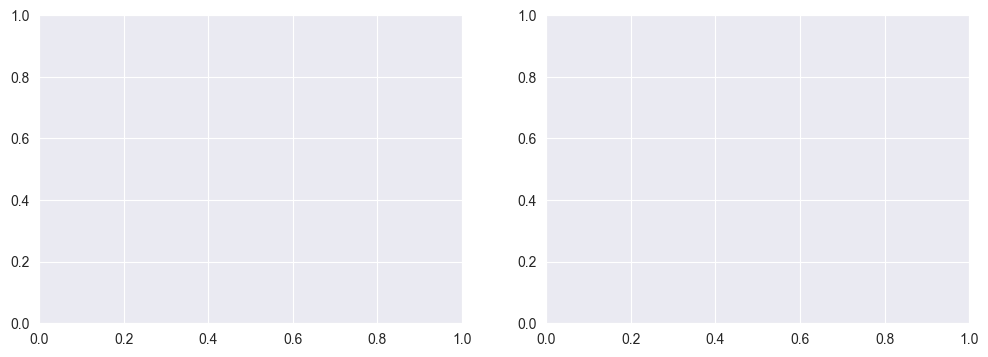

In [7]:
# make KDE plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(data=ambulance_calls_df, x="duration_secs", hue="boro_nm", common_norm=False, clip=(-1, 20000), ax=ax[0])
sns.kdeplot(data=ambulance_calls_df, x="arrived_in_secs", hue="boro_nm", common_norm=False, clip=(-1, 10000), ax=ax[1])
plt.show()

What stands out to you from these charts? Make at least two observations.

> - 2.3 #1: ...
> - 2.3 #2: ...
>   
> ...

## Section 3: Aggregations in a choropleth map

You saw that the 911 calls requesting an ambulance all have a latitude and longitude associated with them. That allows us to represent data geographically on a map!

#### Task 3.1: Get NYC boro geometries
First, you'll need the shapefiles or geojson files with the NYC borough boundaries. You can find them [here](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/gthc-hcne). Download the borough boundaries in geojson format, move it to your notebook's working directory, and call your file `borough-boundaries.geojson`. 

Then, use the [geopandas](https://geopandas.org/en/stable/index.html) library, imported above as `gpd`. First, use the `read_file()` function to read your geojson file into a geodataframe called `nyc_boros`. Then, display the geodataframe.

In [11]:
if __name__ == "__main__":
# Section 3: Choropleth Map
    nyc_boros = gpd.read_file("borough-boundaries.geojson")

    # Ensure borough names match between datasets
    nyc_boros['boro_name'] = nyc_boros['boro_name'].replace({'The Bronx': 'Bronx'})

    filtered = ambulance_calls_df[
        (ambulance_calls_df["arrived_in_secs"] > 0) &
        (ambulance_calls_df["boro_nm"].notna()) &
        (ambulance_calls_df["arrived_ts"].notna())
    ]
    calls_by_boro = filtered.groupby("boro_nm").agg(
        num_calls=("incident_ts", "size"),
        median_arrived_in_secs=("arrived_in_secs", "median"),
        median_duration_secs=("duration_secs", "median")
    ).reset_index()

DataSourceError: 'borough-boundaries.geojson' not recognized as being in a supported file format. It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.

In [19]:
# display the geodataframe with the NYC boroughs
nyc_boros

NameError: name 'nyc_boros' is not defined

#### Task 3.2: First look at a geodataframe

This is (probably) your first time looking at a geodataframe. What do you notice? Write at least two observations:

> - 3.2 #1: ...
> - 3.2 #2: ...
> - ...

#### Task 3.3: Choropleth map of typical arrival times by borough
Now let's use these geometries together with the ambulance data to make an interactive choropleth map of the typical arrival time of help after a call is made on the five boroughs. You will also display other quantities a hover properties.

First off, aggregate `ambulance_calls_df` into a new dataframe called `calls_by_boro` which should have the following columns: 
- `"boro_nm"`
- `"num_calls"`
- `"median_arrived_in_secs"`
- `"median_duration_secs"`

Before you group your dataframe, you should remove any rows where `"arrived_in_secs"` is not larger than `0` (clearly something is wrong with those data points), as well as rows where the borough name or the `"arrived_ts"` are null or missing. 

_**Hint**: you may find the `.agg()` dataframe method helpful to apply different aggregation functions to different columns._

In [18]:
# aggregate ambulance_calls_df by borough
filtered = ambulance_calls_df[
    (ambulance_calls_df["arrived_in_secs"] > 0) &
    (ambulance_calls_df["boro_nm"].notna()) &
    (ambulance_calls_df["arrived_ts"].notna())
]
calls_by_boro = filtered.groupby("boro_nm").agg(
    num_calls=("incident_ts", "size"),
    median_arrived_in_secs=("arrived_in_secs", "median"),
    median_duration_secs=("duration_secs", "median")
).reset_index()

KeyError: 'arrived_in_secs'

In [19]:
# display the dataframe
calls_by_boro

NameError: name 'calls_by_boro' is not defined

Then, merge the `calls_by_boro` pandas dataframe into the `nyc_boros` geodataframe. Make sure to call `nyc_boros.merge(...)`, as the resulting object will preserve the type of the left frame. Name the new table `choropleth_gdf`. Finally, set the frame's index to `"boro_name"` and display it.

In [22]:
choropleth_gdf = nyc_boros.merge(calls_by_boro, left_on="boro_name", right_on="boro_nm")

NameError: name 'nyc_boros' is not defined

In [21]:
# display the new geodataframe
choropleth_gdf

NameError: name 'choropleth_gdf' is not defined

Now you have a single geodataframe with the geometries for each borough and a number of metrics describing them. This is all you need to make your choropleth map with plotly.

You'll be using the `choropleth_mapbox(...)` function of the `plotly.express` module (imported above with the typical alias `px`). You can find the documentation [here](https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html). Call the function setting the following parameters:
- `data_frame`: this is your geodataframe containing the borough-level data; it's important that the index is a unique label to each geometry.
- `geojson`: an array or `pandas.Series` with the geometries associated to each element.
- `locations`: an array containing your location identifiers. In our case, `choropleth_gdf.index` is a good choice.
- `color`: column name contaning values to be represented in choropleth: `"median_arrived_in_secs"`
- `hover_data`: additional column names with data to be represented when hovering over a geometry; let's include `["num_calls", "median_duration_secs"]`, but feel free to add others.
- `labels`: a dictionary with the display names for different plot properties. Use this to make your column names more human readable:
  -  `"boro_name": "borough"` 
  - `"num_calls": "number of calls"`
  - `"median_arrived_in_secs": "median arrival time (seconds)"`
  - `"median_duration_secs": "median duration time (seconds)"`
- `title` (optional): a title for your choropleth!
- `mapbox_style`: set this to `"carto-darkmatter"` to make a map with a black background, but feel free to play with other styles too (see [docs](https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html)).
- `center`: set this to `{"lat": 40.75, "lon": -74.0}` to center the map in NYC
- `zoom`: set this to `9`:
- `height`: set it to `750`
- `width`: set it to `750`

Store the output of your function call as `choropleth_fig`, and finally call `choropleth_fig.show();` to display your choropleth.

In [ ]:
# make and show the choropleth
if __name__ == "__main__":
    choropleth_fig = px.choropleth_mapbox(
        choropleth_gdf,
        geojson=choropleth_gdf.geometry,
        locations=choropleth_gdf.index,
        color="median_arrived_in_secs",
        hover_data=["num_calls", "median_duration_secs"],
        labels={
            "boro_name": "Borough",
            "num_calls": "Number of Calls",
            "median_arrived_in_secs": "Median Arrival Time (seconds)",
            "median_duration_secs": "Median Duration (seconds)"
        },
        mapbox_style="carto-darkmatter",
        center={"lat": 40.75, "lon": -74.0},
        zoom=9,
        height=750,
        width=750
    )
    choropleth_fig.show()

#### Task 3.4: Analyze the choropleth
What do you observe in your choropleth? Write at least two thoughts:

> - 3.4 #1: ...
> - 3.4 #2: ...
> 
> - ...

## Section 4: scatter map of individual calls
Now let's make a geographic scatterplot of individual ambulance call arrival times using the `px.scatter_mapbox()` function (docs [here](https://plotly.com/python-api-reference/generated/plotly.express.scatter_mapbox.html)).

For this map you won't need a geodataframe as `ambulance_calls_df` contains latitude and longitude columns and `scatter_mapbox()` can take those as arguments. 

#### Task 4.1: Make a new dataframe for the scattermap
First, make a new pandas dataframe called `new_years_df` that is a subset of `ambulance_calls_df` with
- `"incident_ts"` being equal to `"2024-01-01"`
- no missing/null values

In [ ]:
new_years_df = ambulance_calls_df[
    (ambulance_calls_df["incident_ts"].dt.date == pd.to_datetime("2024-01-01").date()) &
    (ambulance_calls_df["latitude"].notna()) &
    (ambulance_calls_df["longitude"].notna())
]

#### Task 4.2: Create the scatter map
Now you'll create your scatter map. You'll do this in two steps: first you'll create the scatter map, then you'll add the boro boundaries as another layer.

Storing its result as `scatter_fig`, call `px.scatter_mapbox` passing the following parameters:
- `data_frame`
- `lat`
- `lon`
- `size`
- `opacity`
- `color`
- `title`
- `zoom`
- `height`
- `width`

That will create the scatter map (feel free to check your work before moving on). Then, call `scatter_fig.update_layout()`, setting the `mapbox_layers` parameter to the following value:

```python
[{
    "type": "line",
    "color": "white",
    "opacity": 0.5,
    "source": json.loads(nyc_boros["geometry"].to_json()),
    "line": {"width": 0.1},
}]
```

Finally, call `scatter_fig.update_layout(mapbox_style="carto-darkmatter")` to set the theme and call `scatter_fig.show()` to display your map.

In [4]:
scatter_fig = px.scatter_mapbox(
    new_years_df,
    lat="latitude",
    lon="longitude",
    color="arrived_in_secs",
    size="arrived_in_secs",
    opacity=0.7,
    title="Ambulance Calls on New Year's Day 2024",
    zoom=10,
    height=750,
    width=750
)

scatter_fig.update_layout(mapbox_layers=[{
    "type": "line",
    "color": "white",
    "opacity": 0.5,
    "source": json.loads(nyc_boros.geometry.to_json()),
    "line": {"width": 0.1}
}])
scatter_fig.update_layout(mapbox_style="carto-darkmatter")
scatter_fig.show()

NameError: name 'px' is not defined

#### Task 4.3: The slowest arrival
Zoom into your map and look aronud a bit. Can you spot the call with the slowest arrival? Write its latitude and longitude here:
> - latitude: 40.681268 	
> - longitude: -73.892877